#### Import Libraries

In [1]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.optimizers import SGD
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras import DPKerasSGDOptimizer
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import membership_inference_attack as mia
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackInputData, AttackResultsCollection, AttackType, PrivacyMetric, PrivacyReportMetadata, SlicingSpec
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import privacy_report

#### Data Preprocessing

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical

# Load the dataset
data = pd.read_csv('../data/patient_processed.csv')

In [3]:
# Select the relevant columns
features = data[['tanimoto', 'feature_jsim', 'feature_dsim', 'feature_osim']]
labels = data['DDI']

# Map DDI levels to the numeric values
ddi_mapping = {'no interaction found': 0, 'minor': 1, 'moderate': 2, 'major': 3}
labels = labels.map(ddi_mapping)

In [4]:
# Handle missing values
features = features.fillna(features.mean())

In [5]:
# Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    features, 
    labels, 
    test_size=0.2, 
    random_state=42
)

In [6]:
# Scale the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
# Convert the target variable to a categorical format
num_classes = len(ddi_mapping)
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

#### Define Hyperparameters

In [8]:
# Model Hypeparameters
num_features = len(ddi_mapping)
num_classes = X_train_scaled.shape[1]
learning_rate = 0.01
batch_size = 32
epochs = 100

# Privacy Hyperparameters
l2_norm_clip = 1.0
noise_multiplier = 1.1
num_microbatches = 1

#### Build and Compile the Models

##### Model Architecture

In [25]:
import tensorflow as tf
from tensorflow import keras

def create_model(num_features, num_classes, noise_multiplier = 1.1):
    model = keras.Sequential([
        keras.layers.Input(shape=(num_features,)),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(16, activation='relu'),
        keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    optimizer = DPKerasSGDOptimizer(
            l2_norm_clip=l2_norm_clip,
            noise_multiplier=noise_multiplier,
            num_microbatches=num_microbatches,
            learning_rate=learning_rate
        )
    
    model.compile(
        optimizer = optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

##### Differential Privacy Model

In [29]:
# Build a model with differential privacy
model_dp = create_model(num_features, num_classes)

# Use callbacks for early stopping and learning rate scheduling
early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

# Train the model
history = model_dp.fit(
    X_train_scaled, y_train_cat,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    verbose=1,
    callbacks =[early_stopping, lr_scheduler]
)

Epoch 1/10
5/5 [==============================] - 2s 60ms/step - loss: 1.4662 - accuracy: 0.0930 - val_loss: 1.4417 - val_accuracy: 0.0303 - lr: 0.0100
Epoch 2/10
5/5 [==============================] - 0s 14ms/step - loss: 1.4555 - accuracy: 0.0930 - val_loss: 1.4581 - val_accuracy: 0.0303 - lr: 0.0100
Epoch 3/10
5/5 [==============================] - 0s 14ms/step - loss: 1.4610 - accuracy: 0.1008 - val_loss: 1.4520 - val_accuracy: 0.0303 - lr: 0.0100
Epoch 4/10
5/5 [==============================] - 0s 16ms/step - loss: 1.4537 - accuracy: 0.1085 - val_loss: 1.3906 - val_accuracy: 0.3333 - lr: 0.0100
Epoch 5/10
5/5 [==============================] - 0s 17ms/step - loss: 1.4008 - accuracy: 0.3953 - val_loss: 1.3495 - val_accuracy: 0.6061 - lr: 0.0100
Epoch 6/10
5/5 [==============================] - 0s 16ms/step - loss: 1.3609 - accuracy: 0.5504 - val_loss: 1.2590 - val_accuracy: 0.6970 - lr: 0.0100
Epoch 7/10
5/5 [==============================] - 0s 15ms/step - loss: 1.2901 - accuracy

In [30]:
# Evaluate the model
test_loss, test_accuracy = model_dp.evaluate(X_test_scaled, y_test_cat)
print(f"Test accuracy: {test_accuracy}")

2/2 [==============================] - 0s 7ms/step - loss: 1.1640 - accuracy: 0.8293
Test accuracy: 0.8292682766914368


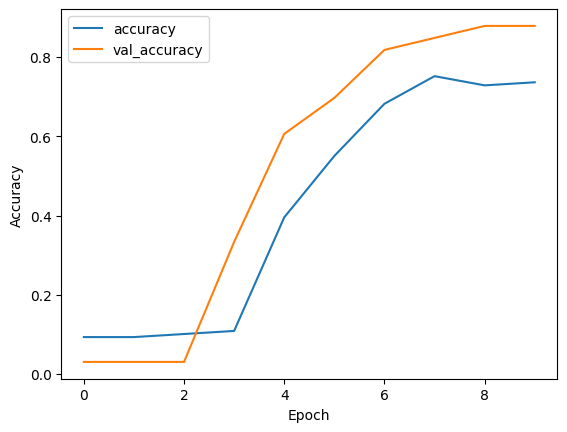

In [31]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

##### Non-Differential Privacy Model

In [13]:
from keras.optimizers import SGD

# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(4,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])

optimizer_dp = DPKerasSGDOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate
)

loss_dp = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.losses.Reduction.NONE)

model_dp.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss=loss_dp, metrics=['accuracy'])

# Train the DP model
model_dp.fit(X_train, y_train, epochs=10, validation_data=(X_train, y_train), batch_size=32)

Epoch 1/10


c:\MONASH\Y3S2\FIT3164\repo\MDS14\.venv\Lib\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


4/4 [==============================] - 1s 79ms/step - loss: 0.9976 - accuracy: 0.7477 - val_loss: 0.9142 - val_accuracy: 0.7477
Epoch 2/10
4/4 [==============================] - 0s 20ms/step - loss: 0.8618 - accuracy: 0.7477 - val_loss: 0.8698 - val_accuracy: 0.7477


c:\MONASH\Y3S2\FIT3164\repo\MDS14\.venv\Lib\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 3/10
4/4 [==============================] - 0s 22ms/step - loss: 0.9042 - accuracy: 0.7477 - val_loss: 0.8240 - val_accuracy: 0.7477
Epoch 4/10
4/4 [==============================] - 0s 20ms/step - loss: 0.8530 - accuracy: 0.7477 - val_loss: 0.8421 - val_accuracy: 0.7477
Epoch 5/10
4/4 [==============================] - 0s 22ms/step - loss: 0.8419 - accuracy: 0.7477 - val_loss: 0.8354 - val_accuracy: 0.7477
Epoch 6/10
4/4 [==============================] - 0s 25ms/step - loss: 0.8570 - accuracy: 0.7477 - val_loss: 0.8169 - val_accuracy: 0.7477
Epoch 7/10
4/4 [==============================] - 0s 21ms/step - loss: 0.8081 - accuracy: 0.7477 - val_loss: 0.8361 - val_accuracy: 0.7477
Epoch 8/10
4/4 [==============================] - 0s 19ms/step - loss: 0.8319 - accuracy: 0.7477 - val_loss: 0.8129 - val_accuracy: 0.7477
Epoch 9/10
4/4 [==============================] - 0s 21ms/step - loss: 0.8095 - accuracy: 0.7477 - val_loss: 0.8077 - val_accuracy: 0.7477
Epoch 10/10
4/4 [==========

#### Evaluating Privacy

##### Evaluating Privacy Budget

In [23]:
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy_lib

epsilon, alpha = compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy(
    n=X_train.shape[0],
    batch_size=batch_size,
    noise_multiplier=noise_multiplier,
    epochs=epochs,
    delta=1e-5
)

print(f"The privacy budget (epsilon) is: {epsilon}")

The privacy budget (epsilon) is: 9.556683175552717


##### Observing Privacy-Utility Tradeoff

In [32]:
noise_multipliers = [0.1, 0.5, 1.0, 2.0]
results = []

for noise_multiplier in noise_multipliers:
    
    print(f"\nTraining with noise multiplier: {noise_multiplier}")
    
    # Create the model
    model = create_model(num_features, num_classes, noise_multiplier)
    
    # Train the model
    history = model.fit(
        X_train_scaled, y_train_cat,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        verbose=0
    )
    
    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test_cat, verbose=0)
    
    # Calculate epsilon
    epsilon, _ = compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy(
        n=len(X_train),
        batch_size=batch_size,
        noise_multiplier=noise_multiplier,
        epochs=epochs,
        delta=1e-5
    )
    
    results.append({
        'noise_multiplier': noise_multiplier,
        'test_accuracy': test_accuracy,
        'epsilon': epsilon
    })
    
    print(f"Test accuracy: {test_accuracy:.4f}")
    print(f"Epsilon: {epsilon:.4f}")
    
# Display results
for result in results:
    print(f"\nNoise Multiplier: {result['noise_multiplier']}")
    print(f"Test Accuracy: {result['test_accuracy']:.4f}")
    print(f"Epsilon: {result['epsilon']:.4f}")


Training with noise multiplier: 0.1


Test accuracy: 0.8537
Epsilon: 2817.4755

Training with noise multiplier: 0.5


Test accuracy: 0.8537
Epsilon: 42.9487

Training with noise multiplier: 1.0


Test accuracy: 0.8537
Epsilon: 11.3460

Training with noise multiplier: 2.0


Test accuracy: 0.8049
Epsilon: 3.8549

Noise Multiplier: 0.1
Test Accuracy: 0.8537
Epsilon: 2817.4755

Noise Multiplier: 0.5
Test Accuracy: 0.8537
Epsilon: 42.9487

Noise Multiplier: 1.0
Test Accuracy: 0.8537
Epsilon: 11.3460

Noise Multiplier: 2.0
Test Accuracy: 0.8049
Epsilon: 3.8549


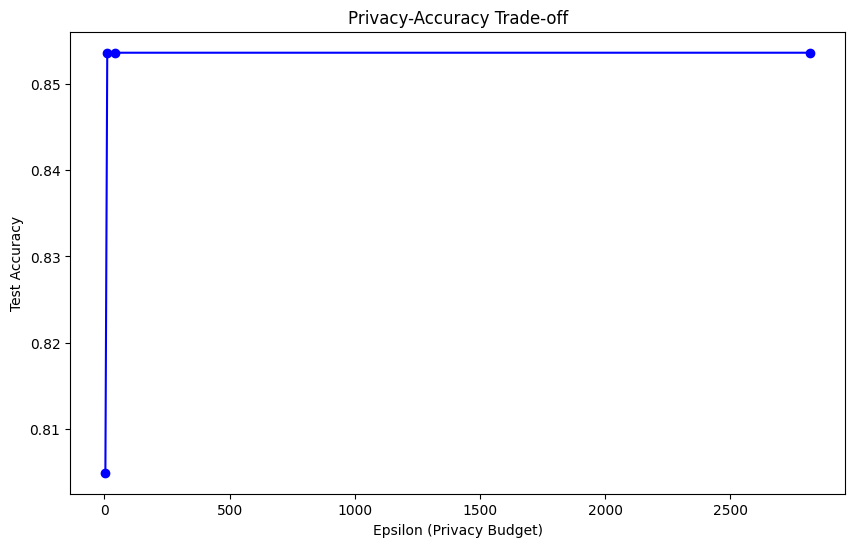

In [33]:
import matplotlib.pyplot as plt

epsilons = [result['epsilon'] for result in results]
accuracies = [result['test_accuracy'] for result in results]

plt.figure(figsize=(10, 6))
plt.plot(epsilons, accuracies, 'bo-')
plt.xlabel('Epsilon (Privacy Budget)')
plt.ylabel('Test Accuracy')
plt.title('Privacy-Accuracy Trade-off')
plt.show()

#### Define Callback for Privacy Metrics

In [14]:
class PrivacyMetrics(tf.keras.callbacks.Callback):
    def __init__(self, epochs_per_report, model_name):
        self.epochs_per_report = epochs_per_report
        self.model_name = model_name
        self.attack_results = []

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.epochs_per_report != 0:
            return

        logits_train = self.model.predict(X_train, batch_size=batch_size)
        logits_test = self.model.predict(X_test, batch_size=batch_size)

        prob_train = tf.nn.softmax(logits_train, axis=1)
        prob_test = tf.nn.softmax(logits_test, axis=1)

        privacy_report_metadata = PrivacyReportMetadata(
            accuracy_train=logs['accuracy'],
            accuracy_test=logs['val_accuracy'],
            epoch_num=epoch + 1,
            model_variant_label=self.model_name
        )

        attack_results = mia.run_attacks(
            AttackInputData(
                labels_train=y_train,
                labels_test=y_test,
                probs_train=prob_train,
                probs_test=prob_test
            ),
            SlicingSpec(entire_dataset=True, by_class=True),
            attack_types=(AttackType.THRESHOLD_ATTACK, AttackType.LOGISTIC_REGRESSION),
            privacy_report_metadata=privacy_report_metadata
        )

        self.attack_results.append(attack_results)

#### Train Model and Collect Privacy Metrics

In [15]:
callback = PrivacyMetrics(epochs_per_report=2, model_name="DP Model")
history = model_dp.fit(
    X_train, y_train,
    epochs=epochs,
    validation_data=(X_test, y_test),
    batch_size=batch_size,
    callbacks=[callback]
)

Epoch 1/10
4/4 [==============================] - 0s 33ms/step - loss: 0.7836 - accuracy: 0.7477 - val_loss: 1.0185 - val_accuracy: 0.6071
Epoch 2/10
1/1 [==============================] - 0s 24ms/step


ValueError: probs_train should be a numpy array.

#### Visualise Privacy Metrics

In [ ]:
all_reports = callback.attack_results
results = AttackResultsCollection(all_reports)

##### Epoch Plots

In [ ]:
privacy_metrics = (PrivacyMetric.AUC, PrivacyMetric.ATTACKER_ADVANTAGE)
epoch_plot = privacy_report.plot_by_epochs(results, privacy_metrics=privacy_metrics)

##### Privacy VS Utility Plots

In [ ]:
utility_privacy_plot = privacy_report.plot_privacy_vs_accuracy(results, privacy_metrics=privacy_metrics)
for axis in utility_privacy_plot.axes:
    axis.set_xlabel('Validation accuracy')